# Python impl of constant product

In [2]:
from dataclasses import dataclass


@dataclass
class ConstantProductInvariant:
    a_supply: int
    b_supply: int

    max_pool_supply: int
    pool_supply: int

    scale: int
    fee: int

    def mint(self, a: int, b: int) -> int:
        a_rat = (a * self.scale) // self.a_supply
        b_rat = (b * self.scale) // self.b_supply

        # Use the min of the 2 scaled assets
        to_mint = (min(a_rat, b_rat) * self.issued()) // self.scale

        if to_mint == 0:
            return 0

        # compute first, then tweak balances
        self.a_supply += a
        self.b_supply += b
        self.pool_supply -= to_mint

        return to_mint

    def burn(self, amount) -> tuple[int, int]:
        burn_a = (self.a_supply * amount) // self.issued()
        burn_b = (self.b_supply * amount) // self.issued()

        if burn_a == 0 or burn_b == 0:
            return 0, 0

        # computed first, then tweak balances
        self.a_supply -= burn_a
        self.b_supply -= burn_b
        self.pool_supply += amount

        return burn_a, burn_b

    def swap(self, amount: int, is_a: bool) -> int:

        if is_a:
            swap_amt = self._get_tokens_to_swap(amount, self.a_supply, self.b_supply)
            if swap_amt == 0:
                return 0
            self.a_supply += amount
            self.b_supply -= swap_amt
            return swap_amt

        swap_amt = self._get_tokens_to_swap(amount, self.b_supply, self.a_supply)
        if swap_amt == 0:
            return 0

        self.b_supply += amount
        self.a_supply -= swap_amt
        return swap_amt

    def _get_tokens_to_swap(self, in_amount, in_supply, out_supply) -> int:
        assert in_supply > 0
        assert out_supply > 0
        """ Constant product swap method with fixed input

            X * Y = K

            X, Y are current supply of assets, goal is to keep K the same after adding in_amt and subtracting out amt

            With no fees:
            ------------

            (X + X_in) * (Y - Y_out) = X*Y
            *Algebra happens*
            Y - ( X*Y / (X + X_in)) = Y_out

            With fees:
            ----------

            fee_factor = scale - fee (ex 1000, 3 for a .3% fee)

            X_adj = X_in * (fee_factor)

            (X + X_adj) * (Y - Y_out) = X*Y
            *Algebra happens*
            Y - ( X*Y / (X + X_adj)) = Y_out

            Or as in [Tinyman](https://github.com/tinymanorg/tinyman-contracts-v1/blob/main/contracts/validator_approval.teal#L1000):
            Y_out = (X_adj * Y) / (X * scale + X_adj)
        """

        # Simple, no fees
        # out_amt = out_supply - ((in_supply * out_supply) / (in_supply + in_amount))

        # with fees
        factor = self.scale - self.fee
        out_amt = (in_amount * factor * out_supply) / (
            (in_supply * self.scale) + (in_amount * factor)
        )

        return int(out_amt)

    def scaled_ratio(self) -> int:
        return int(self.ratio() * self.scale)

    def issued(self) -> int:
        return self.max_pool_supply - self.pool_supply

    def ratio(self):
        return self.a_supply / self.b_supply

In [3]:
import numpy as np
from copy import copy


class Simulator:
    def __init__(self):
        self.cpi = ConstantProductInvariant(
            a_supply=int(3e7),
            b_supply=int(1e6),
            max_pool_supply=int(1e9),
            pool_supply=int(1e9) - 100000,
            scale=1000,
            fee=3,
        )

        self.states = []

    def run_mints(self, num: int = 100):
        self.sizes = np.random.randint(100, 1000, num)
        for size in self.sizes:
            # force them to be the right ratio
            a_size = size * self.cpi.ratio()
            b_size = size

            self.cpi.mint(a_size, b_size)
            self.states.append(copy(self.cpi))

    def run_burns(self, num: int = 100):
        self.sizes = np.random.randint(100, 10000000, num)
        for size in self.sizes:
            # Get a reasonable size given number of issued tokens
            # should be ~ 1% --> 0.0001% burns
            size = self.cpi.issued() // size
            self.cpi.burn(size)
            self.states.append(copy(self.cpi))

    def run_swaps(self, num: int = 100):

        self.sizes = np.random.randint(10, 1000, num)
        for idx, size in enumerate(self.sizes):
            a_swap = (idx + size) % 2 == 0
            # Re-size if its an a_swap
            size *= self.cpi.ratio() if a_swap else 1
            _ = self.cpi.swap(size, a_swap)
            self.states.append(copy(self.cpi))

    def run_mix(self, num=100):
        nums = np.random.randint(1, 4, num)
        for idx, runs in enumerate(nums):
            v = (idx + runs) % 3
            match v:
                case 0:
                    self.run_mints(runs)
                case 1:
                    self.run_burns(runs)
                case 2:
                    self.run_swaps(runs)

    def get_states_for(self, k: str) -> list[int]:
        if hasattr(self.cpi, k):
            return [getattr(c, k) for c in self.states]
        return []

    def get_states(self) -> dict[str, list[int]]:
        states: dict[str, list[int]] = {}
        for key in self.cpi.__annotations__.keys():
            states[key] = self.get_states_for(key)

        del states["scale"]
        del states["fee"]
        del states["max_pool_supply"]

        states["ratio"] = [s.ratio() for s in self.states]
        return states

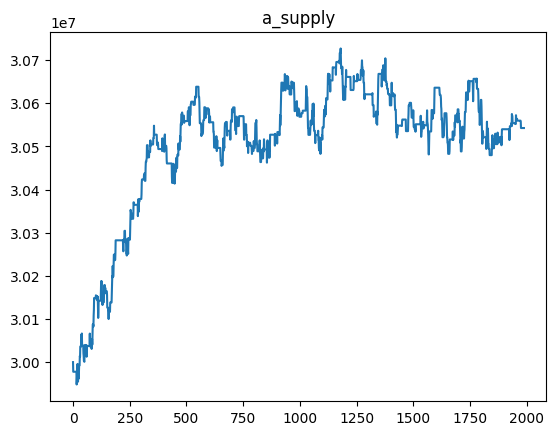

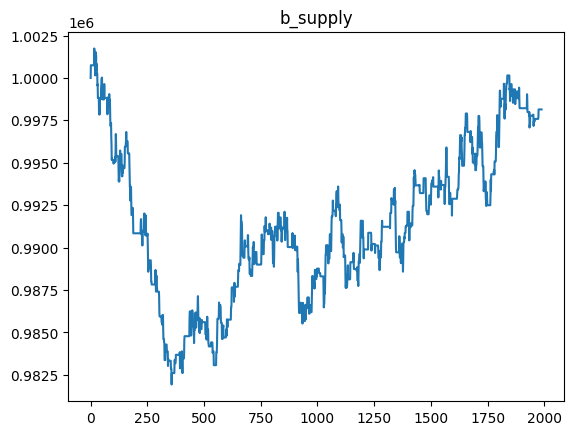

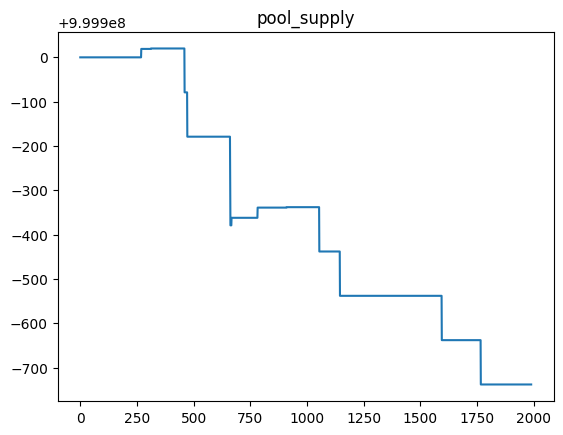

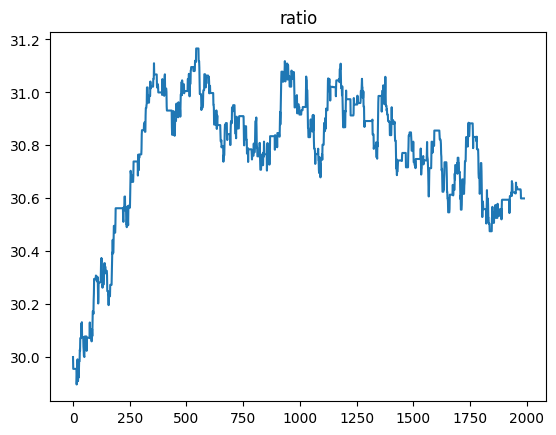

In [4]:
import matplotlib.pyplot as plt

sim = Simulator()
sim.run_mix(num=1000)
states = sim.get_states()
for k, v in states.items():
    plt.title(k)
    plt.plot(v)
    plt.show()